In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.fakeflares import aflare

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import pytest

from funcs.model import daylength

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [2]:
 

def on_off(phi, daylength, phi0=0.):
    """Calculate the visibility step function
    of a point on a rotating sphere as a function of
    longitude phi.
    
    phi0 is facing the observer.
    
    Parameters:
    ------------
    phi : array
        longitudes
    daylength : float
        fraction of rotation period (0,1)
    phi0 : float 
        longitude to start with
        default 0
    
    
    """
    # everything is visible by default
    res = np.full(phi.shape[0],1) 
    
    # if longitude is on the night side, set visibility to 0:
    res[((phi-phi0)%(2*np.pi) > daylength*np.pi) & ((phi-phi0)%(2*np.pi) < (2-daylength)*np.pi)] = 0
    
    return res

In [3]:
def lambert(phi,i,l):
    """Calculate Lambert's law of geometric
    brightness modulation (prop. cos(incident angle))
    from known stellar inclination, and the 
    spots latitude and longitudes.
    
    Parameters:
    -----------
    phi : array
        longitudes
    i : float
        inlcination in rad
    l : float
        latitude in rad
        
    Return:
    -------
    Array of values between 0 and 1 that define the 
    fraction of the flux that we would receive from 
    a point at the center of the stellar disk.
    
    Wikipedia is great:
    https://en.wikipedia.org/wiki/Great-circle_distance
    https://en.wikipedia.org/wiki/Lambert%27s_cosine_law
    """
    #print((np.sin(l) * np.cos(i) + np.cos(l) * np.sin(i) * np.cos(phi)).shape)
    
    return np.sin(l) * np.cos(i) + np.cos(l) * np.sin(i) * np.cos(phi)

In [4]:
def great_circle_distance(a, la, b, lb):
    """a, b latitude
    la, lb longitude
    """
    return np.arccos(np.sin(a) * np.sin(b) + np.cos(a) * np.cos(b) * np.cos(la-lb))

def dot_ensemble(lat, lon, radius, num_pts=1e5):
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices/num_pts) #latitude
    theta = np.pi * (1 + 5**0.5) * indices #longitue
    gcs = great_circle_distance(lat, lon,
                                np.pi / 2 - phi % (2 * np.pi),
                                theta % (np.pi * 2))
    a = np.where(gcs < (radius * np.pi / 180))[0]
    phi2 = np.pi/2 - phi[a]%(2*np.pi)
    theta2 = theta[a]%(np.pi*2)
    return phi2, theta2

In [8]:
def model(phi, latitudes, longitudes, flare, inclination):
    """Take a flare light curve and a rotating ensemble of latitudes
    and longitudes, and let it rotate. 
    
    Parameters:
    -----------
    phi :  N-array
        longitudes to evaluate the model at in rad
    latitudes : M-array
        latitudes of the spot grid points in rad
    longitudes : M-array
        longitudes of the spot grid points in rad
    flare : N-array
        flare shape
    inclination : float
        inclination in rad
    """
    l = len(latitudes)
    assert len(latitudes) == len(longitudes)
    latlon = np.concatenate((latitudes.reshape(l,1),
                             longitudes.reshape(l,1)),
                            axis=1)
    
    Ds = daylength(latlon[:,0], inclination)
    onoff = np.full((latlon.shape[0],phi.shape[0]),0)
    
    for i,d in enumerate(Ds):
        onoff[i,:] = on_off(phi-latlon[i,1], d)
        
    A = []
    for i, ll in enumerate(latlon):
        a = lambert(phi-ll[1], I, ll[0])
        A.append(a)
    lamb = np.array(A)
    return lamb, onoff, np.sum(lamb * onoff, axis=0) * flare / l

### Plots 

Text(0, 0.5, 'latitude [deg]')

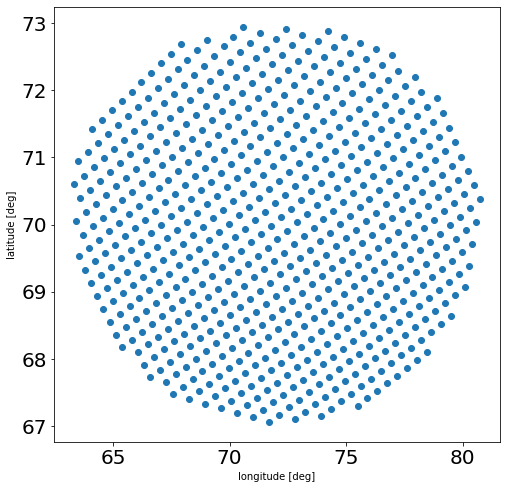

In [63]:
# plot a grid

#latitudes, longitudes = dot_ensemble(np.pi/2-np.pi/8,np.pi/2-np.pi/10,4,num_pts=1e6)
latitudes, longitudes = dot_ensemble(70/180*np.pi,np.pi/2-np.pi/10,3,num_pts=1e6)
plt.figure(figsize=(8,8))
plt.scatter(longitudes/np.pi*180, latitudes/np.pi*180)
#plt.scatter([180/2-180/10],[180/2-180/8],)
plt.xlabel("longitude [deg]")
plt.ylabel("latitude [deg]")
#plt.savefig(f"{CWD}/analysis/plots/model/dot_ensemble.png",dpi=300)

In [69]:
# Plot a model consisting of an ensemble of rotating flaring points on a sphere

I = 71 * np.pi / 180.
phi = np.linspace(0,6*np.pi,2000)
ampl = 20
fwhm = 3.
flare = aflare(phi, 3.1, fwhm, ampl,)

lamb, onoff, m = model(phi, latitudes, longitudes, flare, I)

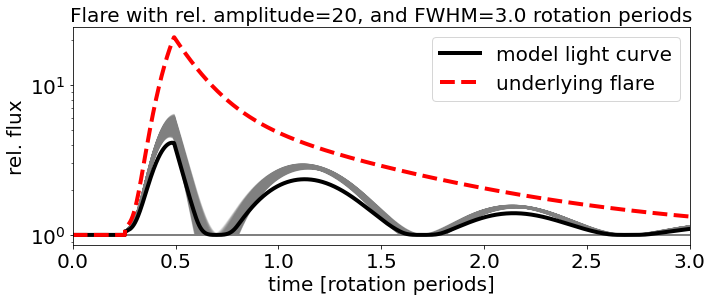

In [72]:
plt.figure(figsize=(10,4))
for l,oo in zip(lamb,onoff):
    plt.plot(phi/2/np.pi, l*oo*flare+1, alpha=.1, c="grey")
plt.plot(phi/2/np.pi,m+1,c="k",linewidth=4, label="model light curve")#,\naverage of individual\ngrid dots (in grey)")
plt.plot(phi/2/np.pi,flare+1, label="underlying flare",c="r",linestyle="dashed",linewidth=4)
plt.xlabel("time [rotation periods]",fontsize=20)
plt.ylabel("rel. flux",fontsize=20)
plt.xlim(0,3)
plt.legend(fontsize=20)
plt.yscale("log")
plt.tight_layout()
plt.title(f"Flare with rel. amplitude={ampl}, and FWHM={fwhm} rotation periods",fontsize=20)
plt.savefig(f"{CWD}/analysis/plots/model/rotating_flaring_ensemble_lightcurve.png",dpi=300);


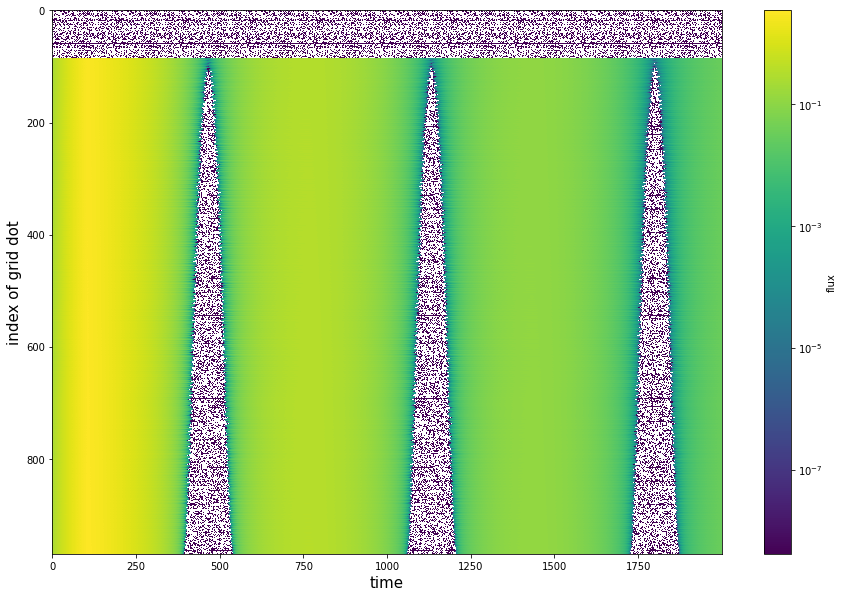

In [297]:
# create a heatmap of an ensemble of rotating flaring points on a sphere (need the cell above)
from matplotlib.colors import LogNorm
plt.figure(figsize=(15,10))
plt.imshow((lamb*onoff*flare)[:,:], norm=LogNorm(),aspect="auto")
plt.colorbar(label="flux")
plt.xlabel("time",fontsize=15)
plt.ylabel("index of grid dot",fontsize=15)
plt.savefig(f"{CWD}/analysis/plots/model/rotating_flaring_ensemble_heatmap.png",dpi=300)

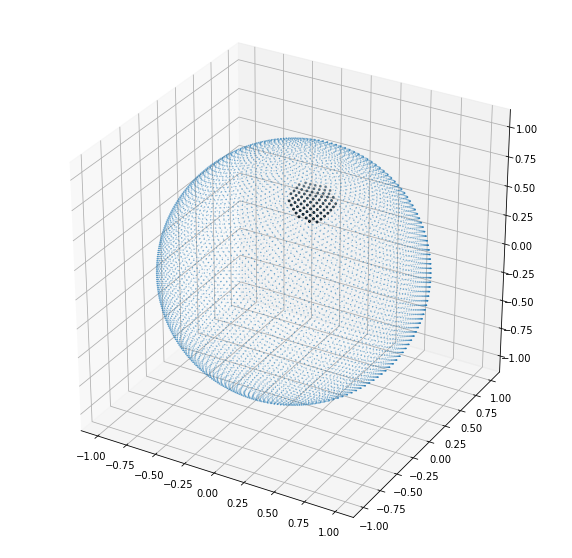

In [296]:
# 10% percent area spot on the stellar surface
percent = 10
num_pts=1e4
indices = np.arange(0, num_pts, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/num_pts) #latitude
theta = np.pi * (1 + 5**0.5) * indices  #longitude

a = np.where(great_circle_distance(np.pi/3,- np.pi/4, np.pi/2 - phi%(2*np.pi), theta%(np.pi*2))<(percent/180*np.pi))[0]
phi2 = phi[a]
theta2 = theta[a]

x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
x2, y2, z2 = np.cos(theta2) * np.sin(phi2), np.sin(theta2) * np.sin(phi2), np.cos(phi2);
ax = plt.figure(figsize=(10,10)).add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=.1);
ax.scatter(x2, y2, z2, s=3.5, c="k");
plt.savefig(f"{CWD}/analysis/plots/model/10percent_spot_on_a_sphere.png",dpi=300)

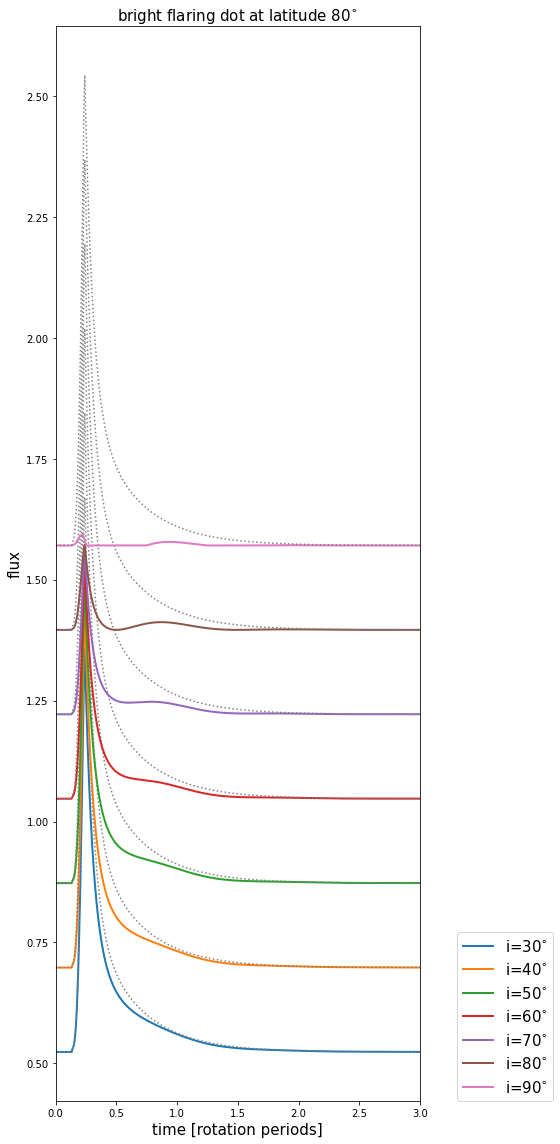

In [92]:
# plot a rotaionally modulated dot-flare
flare = aflare(phi, 1.5, 1.3, 1,)
plt.figure(figsize=(8,16))
l = 80/180*np.pi
I = np.arange(30,91,10)/180*np.pi
for i in I:
    D = daylength(l,i)
    modulation = lambert(phi,i,l)
    #plt.plot(phi/2/np.pi,modulation*on_off(D,phi),label=f"i={i/np.pi*180:.0f}" + r"$^{\circ}$")
    plt.plot(phi/2/np.pi,modulation*on_off(phi,D)*flare + i,label=f"i={i/np.pi*180:.0f}" + r"$^{\circ}$",
            linewidth=2,)
    plt.plot(phi/2/np.pi,flare + i,c="grey",linestyle="dotted")
plt.title(r"bright flaring dot at latitude 80$^{\circ}$ ",fontsize=15)
plt.xlabel("time [rotation periods]",fontsize=15)
plt.ylabel("flux",fontsize=15)
plt.legend(loc=(1.1,0),fontsize=15)
plt.xlim(0,3)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/rotating_bright_dot_flare.png",dpi=300)

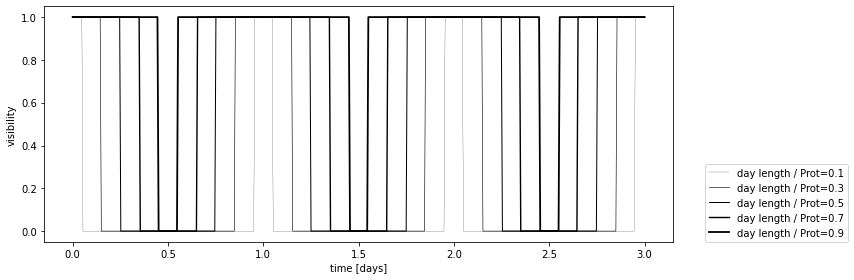

In [85]:
# plot visibility as a function of day time
plt.figure(figsize=(12,4))
phi = np.linspace(0,6*np.pi,500) #(longitude)
daylengths = np.arange(.1,.91,.2)
for d in daylengths:
    plt.plot(phi/2/np.pi, on_off(phi,d), linewidth=d*2,c="k", label=f"day length / Prot={d:.1f}")
plt.legend(loc=(1.05,0))
plt.xlabel("time [days]")
plt.ylabel("visibility")
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/visibility_vs_day.png",dpi=300)

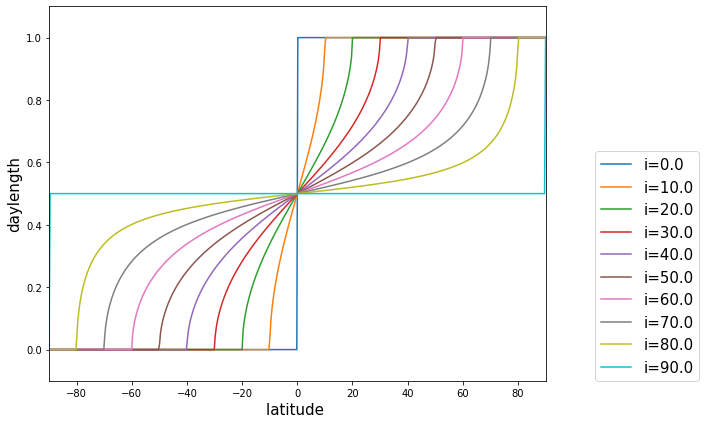

In [84]:
# Plot daylengths:

I = np.linspace(0,np.pi/2,10)
L = np.linspace(-np.pi/2,np.pi/2, 500)[::-1]
plt.figure(figsize=(10,6))

    
for i in I:
    dl = []
    for l in L:
        dl.append(daylength(l,i))
    plt.plot(L/np.pi*180,dl,label=f"i={i/np.pi*180:.1f}")
plt.xlabel("latitude ",fontsize=15)
plt.ylabel("daylength",fontsize=15)
plt.ylim(-.1,1.1)
plt.xlim(-90,90)
plt.legend(loc=(1.1,0),fontsize=15)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/daylength.png",dpi=300)